1.	Необходимо скачать и подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples/notebooks для обучения модели на сегментацию губ (обратите внимание, что сегментация подразумевает уже два класса: фон и губы).
2.	И затем обучить Модель на выбор из segmentation_models_pytorch

In [9]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import cv2

import torch
from torch import nn, optim
from pathlib import Path

import segmentation_models_pytorch as smp

In [31]:
DATASET_FILEPATH = Path('./set-lipstick-original')
image_path = DATASET_FILEPATH.joinpath('720p')
mask_path = DATASET_FILEPATH.joinpath('mask')
list_csv_path = DATASET_FILEPATH.joinpath('list.csv')

In [32]:
df_lips_images = pd.read_csv(list_csv_path)
df_lips_images.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [7]:
df_lips_images = df_lips_images[['filename', 'mask']]
df_lips_images.head()

,filename,mask
0,image00000001.jpg,mask00000001.png
1,image00000002.jpg,mask00000002.png
2,image00000003.jpg,mask00000003.png
3,image00000004.jpg,mask00000004.png
4,image00000005.jpg,mask00000005.png


In [14]:
list_of_an_images = sorted([i for i in Path(image_path).iterdir()])
list_of_a_masks = sorted([i for i in Path(mask_path).iterdir()])
len(list_of_an_images), len(list_of_a_masks)

(28594, 28540)

In [15]:
df_lips_images = df_lips_images.loc[df_lips_images['mask'].isin([i.name for i in list_of_a_masks])]
df_lips_images.reset_index(drop=True, inplace=True)
df_lips_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28540 entries, 0 to 28539
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  28540 non-null  object
 1   mask      28540 non-null  object
dtypes: object(2)
memory usage: 446.1+ KB


In [24]:
IMG_SIZE = 256

In [28]:
def resize_an_image_and_mask(image_filename, mask_filename, new_size):
    
    image = cv2.imread(str(image_path.joinpath(image_filename)))
    mask = cv2.imread(str(mask_path.joinpath(mask_filename)))
    
    resized_image = cv2.cvtColor(cv2.resize(image, (new_size, new_size)), cv2.COLOR_BGR2RGB)
    resized_mask = cv2.cvtColor(cv2.resize(mask, (new_size, new_size)), cv2.COLOR_BGR2RGB)
    
    return resized_image, resized_mask


class LipsDataset(torch.utils.data.Dataset):
    
    def __init__(self, data, preprocessing=None):
        
        self.data = data
        self.preprocessing = preprocessing
        
        self.images_paths = self.data.iloc[:, 0]
        self.masks_paths = self.data.iloc[:, 1]
        
        self.data_len = len(self.data.index)
        
    def __len__(self):
        return self.data_len
    
    def __getitem__(self, idx):
        
        img_path = self.images_paths[idx]
        mask_path = self.masks_paths[idx]
        
        img, mask = resize_an_image_and_mask(img_path, mask_path, IMG_SIZE)
        
        img = img.astype(float)
        
        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
        else:
            img = torch.as_tensor(img)
            img /= 255.0
        
        img = img.permute(2, 0, 1)
      
        cls_mask_1 = mask[..., 1]

        cls_mask_1 = np.where(mask > 50, 1, 0)[:,:,1]
        
        cls_mask_1 = cls_mask_1.astype('float')

        masks = [cls_mask_1]
        
        masks = torch.as_tensor(masks, dtype=torch.float)
        
        
        return img.float(), masks

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [20]:
BACKBONE = 'resnet34'

segmodel = smp.Unet(encoder_name=BACKBONE, classes=1, activation='sigmoid')
segmodel.to(device)

preprocess_input = smp.encoders.get_preprocessing_fn(encoder_name=BACKBONE, pretrained='imagenet')

In [21]:
X_train, X_valid = train_test_split(df_lips_images, test_size=0.3,random_state=42)

X_train.reset_index(drop=True, inplace=True)
X_valid.reset_index(drop=True, inplace=True)

train_data = LipsDataset(X_train, preprocessing=preprocess_input)
valid_data = LipsDataset(X_valid, preprocessing=preprocess_input)

In [22]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=4, shuffle=False)

C:\Users\Djo\AppData\Local\Temp/ipykernel_24256/3134291741.py:53: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  masks = torch.as_tensor(masks, dtype=torch.float)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([8, 3, 256, 256])
torch.Size([8, 1, 256, 256])
tensor(0.) tensor(1.)


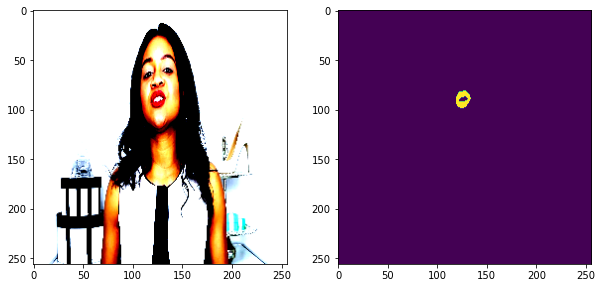

In [33]:
for imgs, masks in train_loader:
    print(imgs.shape)
    print(masks.shape)
    print(masks.min(), masks.max())
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(imgs[0].permute(1, 2, 0))
    ax[1].imshow(masks[0].permute(1, 2, 0))
    break

In [34]:
criterion = smp.utils.losses.BCELoss()
metrics = [smp.utils.metrics.IoU(), ]
optimizer = optim.Adam(segmodel.parameters(), lr=0.001)

In [35]:
train_epoch = smp.utils.train.TrainEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics,
    optimizer=optimizer,
    device=device,
    verbose=True
)

valid_epoch = smp.utils.train.ValidEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics,
    device=device,
    verbose=True
)

# Тренируем модель

In [36]:
max_score = 0

for i in range(0, 1):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(segmodel, './best_model.pth')
        print('Model saved!')

Epoch: 1
train: 100%|█| 2498/2498 [1:11:37<00:00,  1.72s/it, bce_loss - 0.01234, iou_sco
valid: 100%|█| 2141/2141 [12:25<00:00,  2.87it/s, bce_loss - 0.0008383, iou_sco
Model saved!


In [38]:
data_iter = iter(train_loader)
images, labels = data_iter.next()
images, labels = images.to(device), labels.to(device)
outputs = segmodel(images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


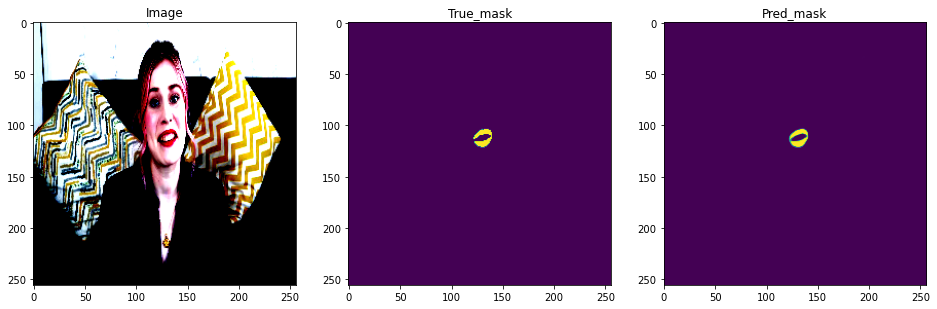

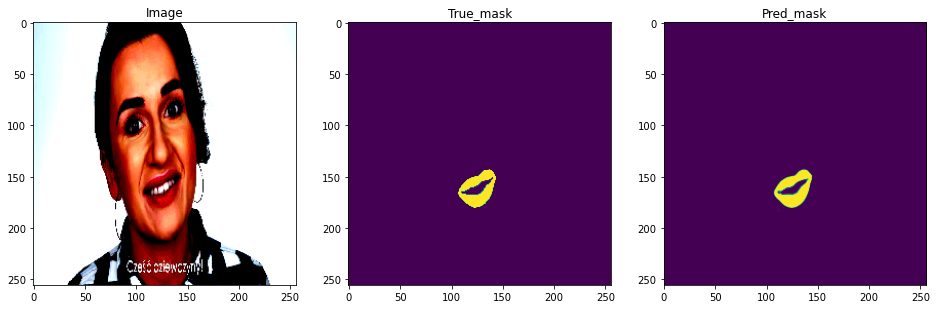

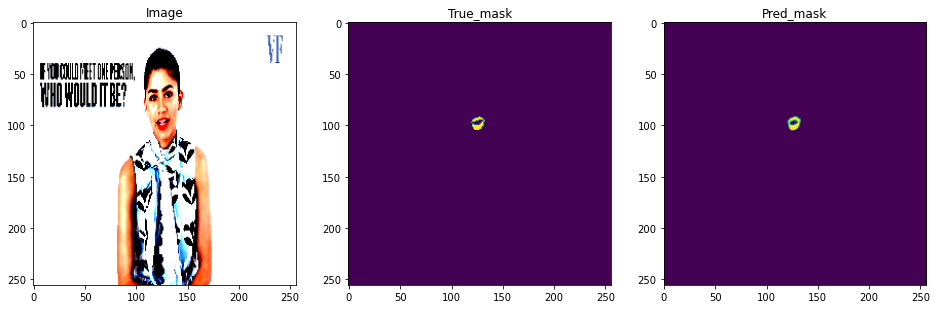

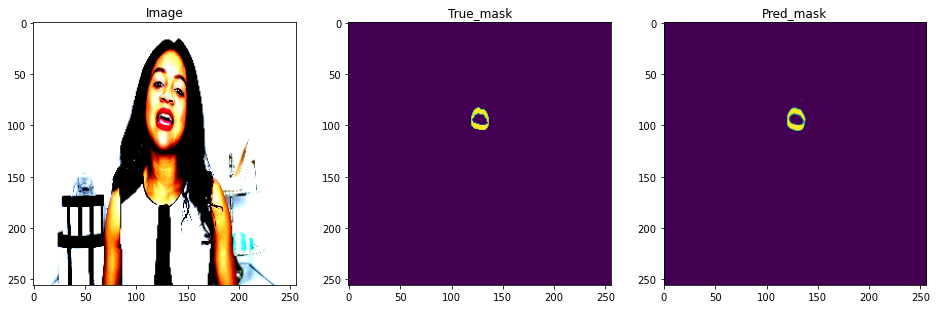

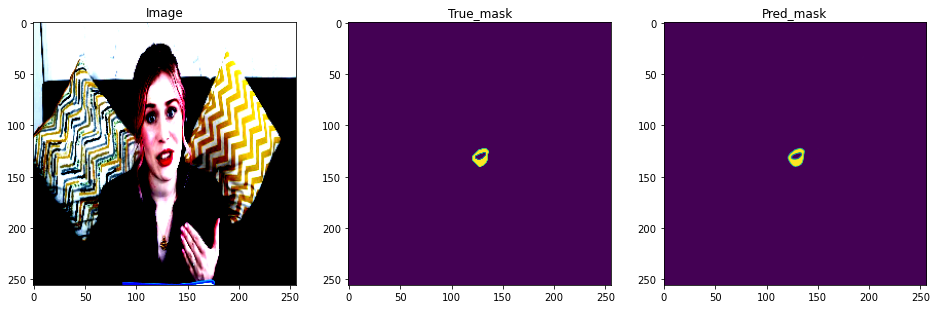

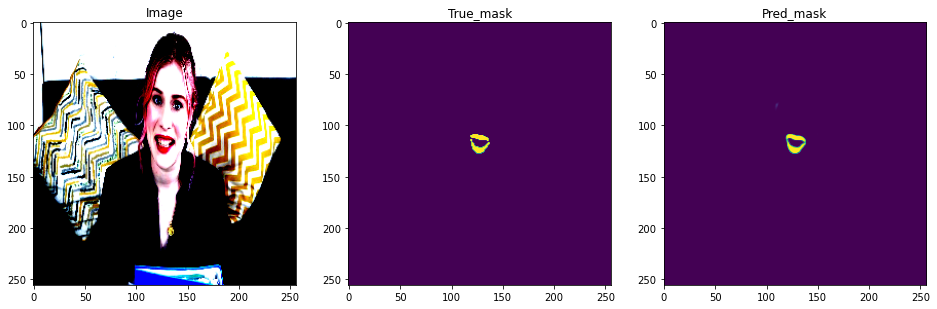

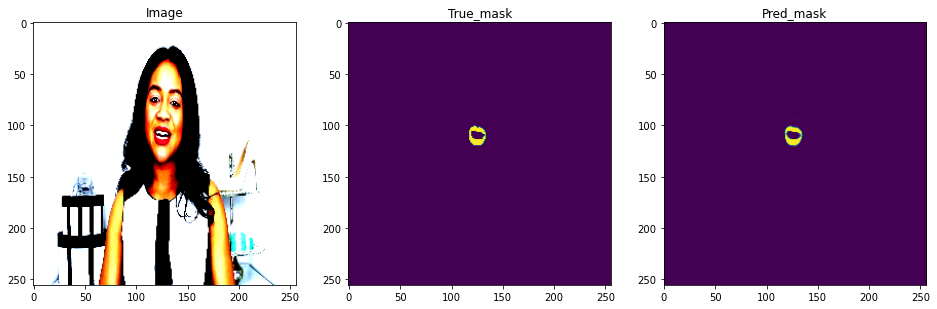

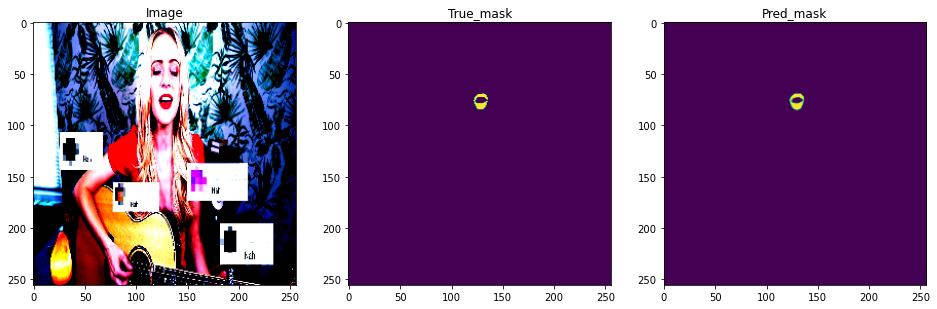

In [39]:
for i in range(images.shape[0]):
    
    fig , (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(16,5))
    
    image = images[i].permute(1, 2, 0)
    
    ax_1.imshow(image.cpu())
    ax_1.set_title('Image')
    
    ax_2.imshow(labels[i, ].cpu().permute(1, 2, 0))
    ax_2.set_title('True_mask')
    
    ax_3.imshow(outputs.detach().cpu()[i, ].permute(1, 2, 0))
    ax_3.set_title('Pred_mask')